In [1]:
%matplotlib inline
from scrape.graph import create_graph_images, generate_boxplot_ci, generate_boxplot_ci_error, generate_boxplot_ci_error_for_days, generate_plot_ci_lines, generate_boxplot_ci_error_per_hour

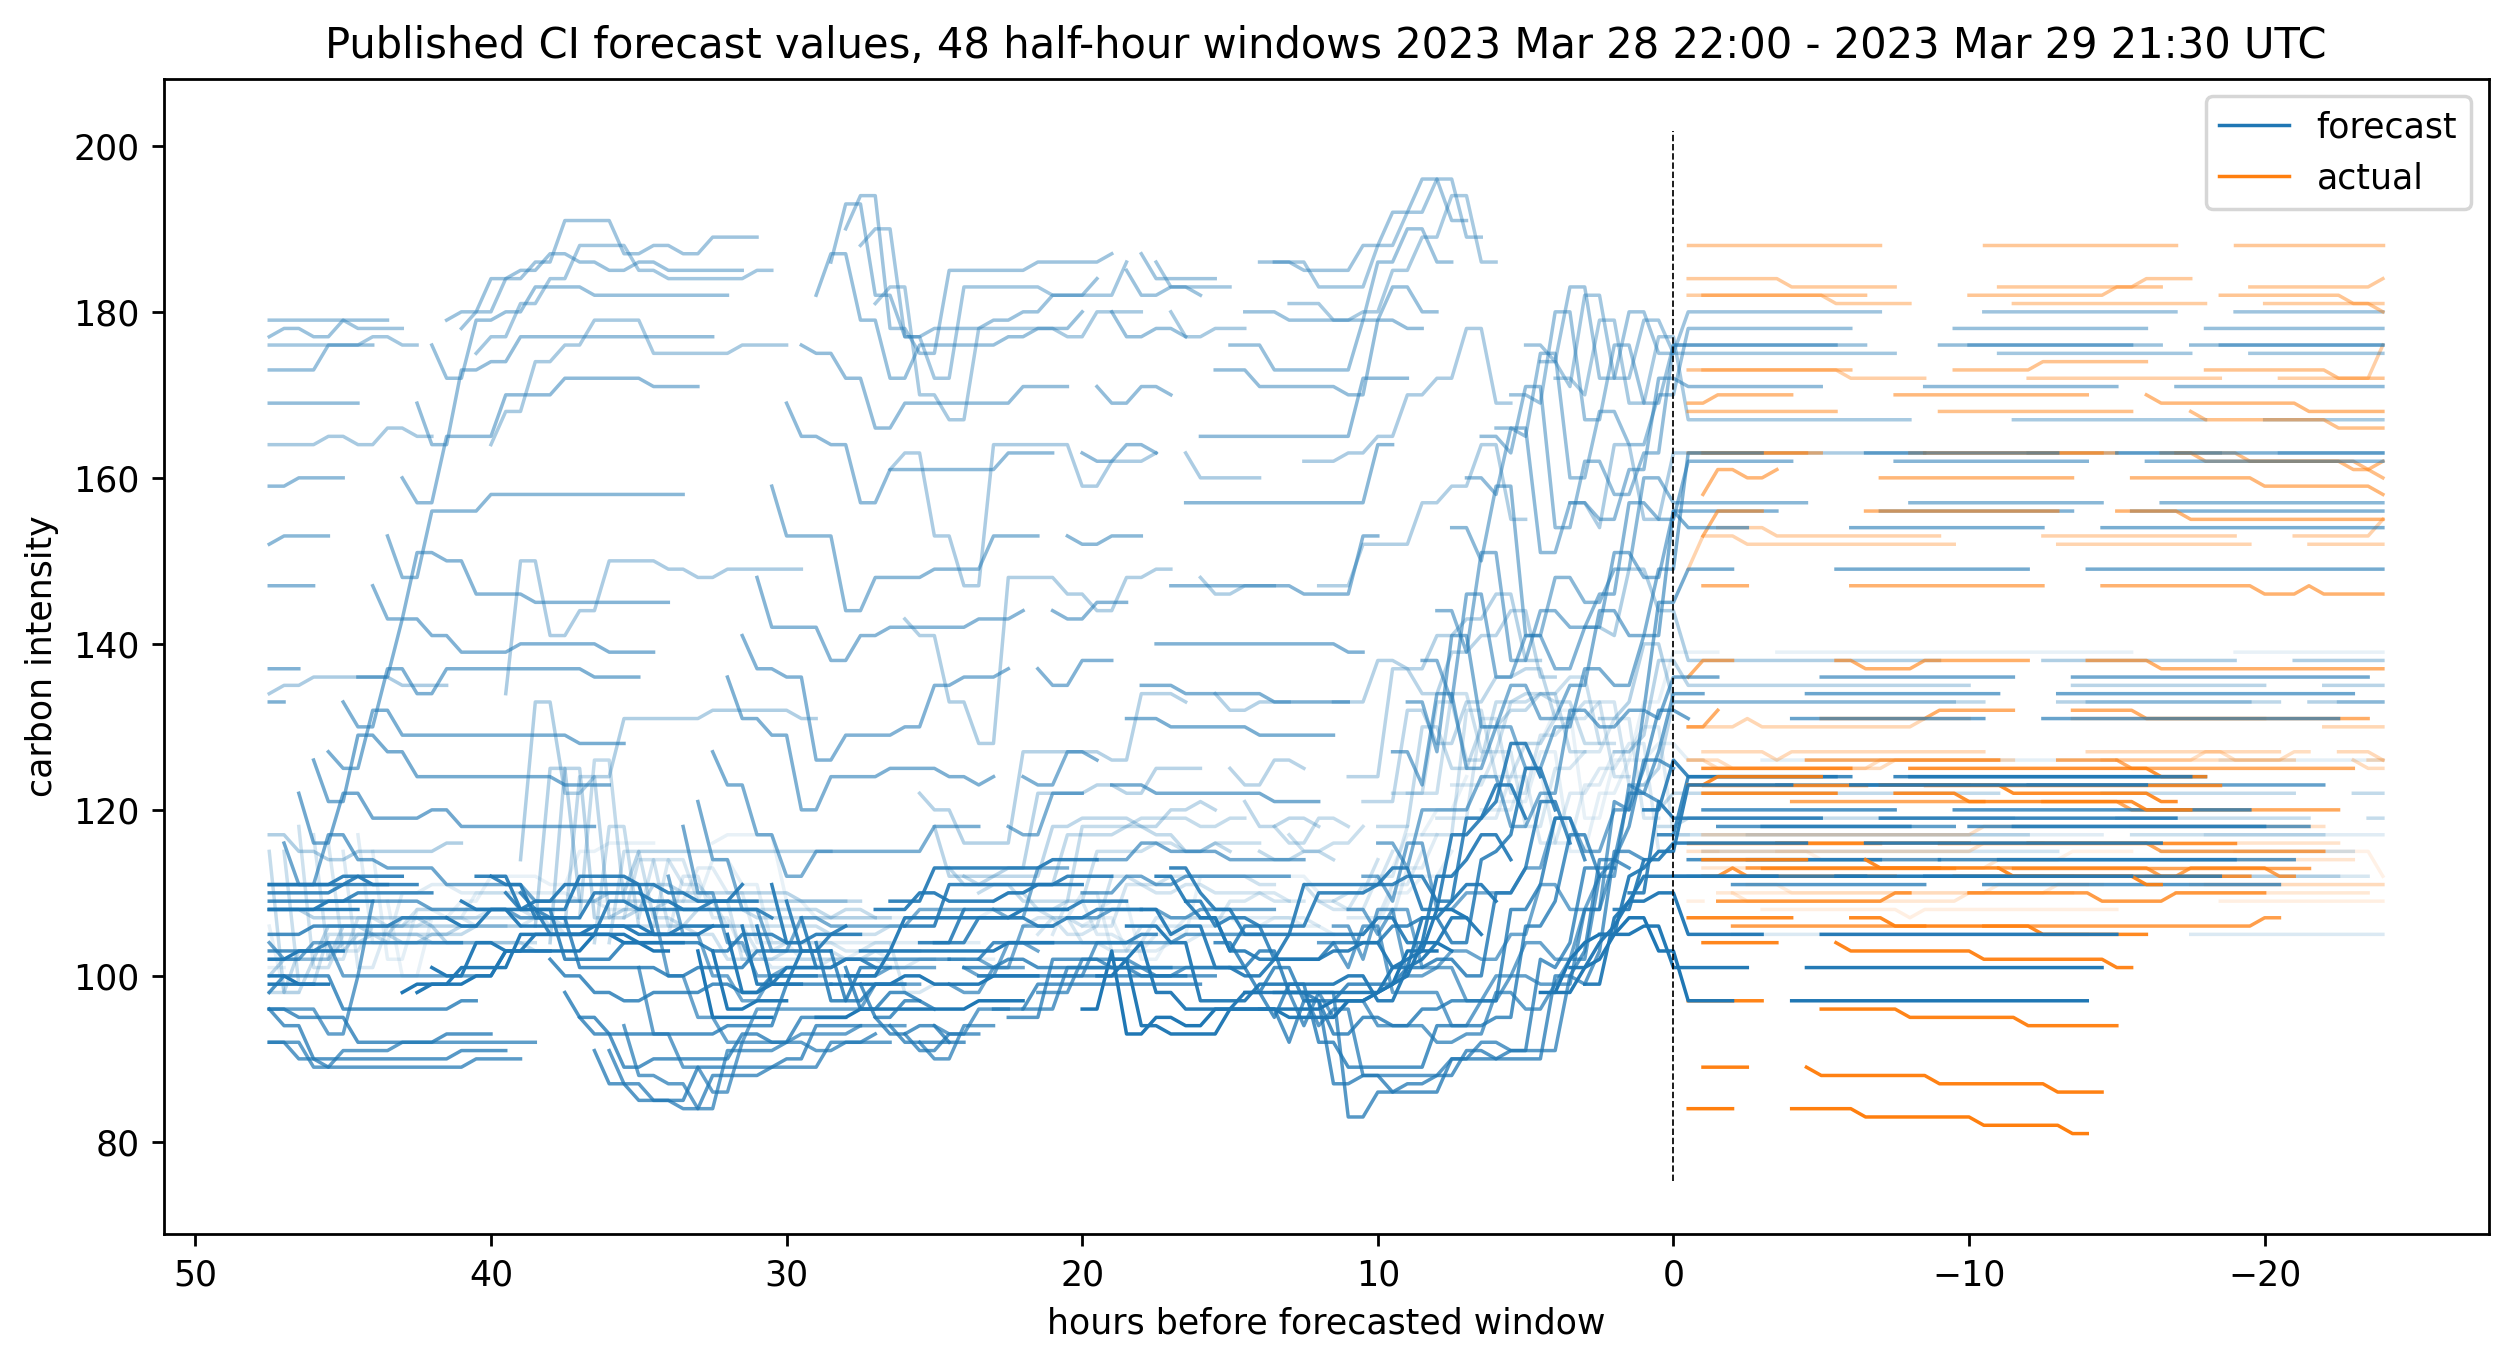

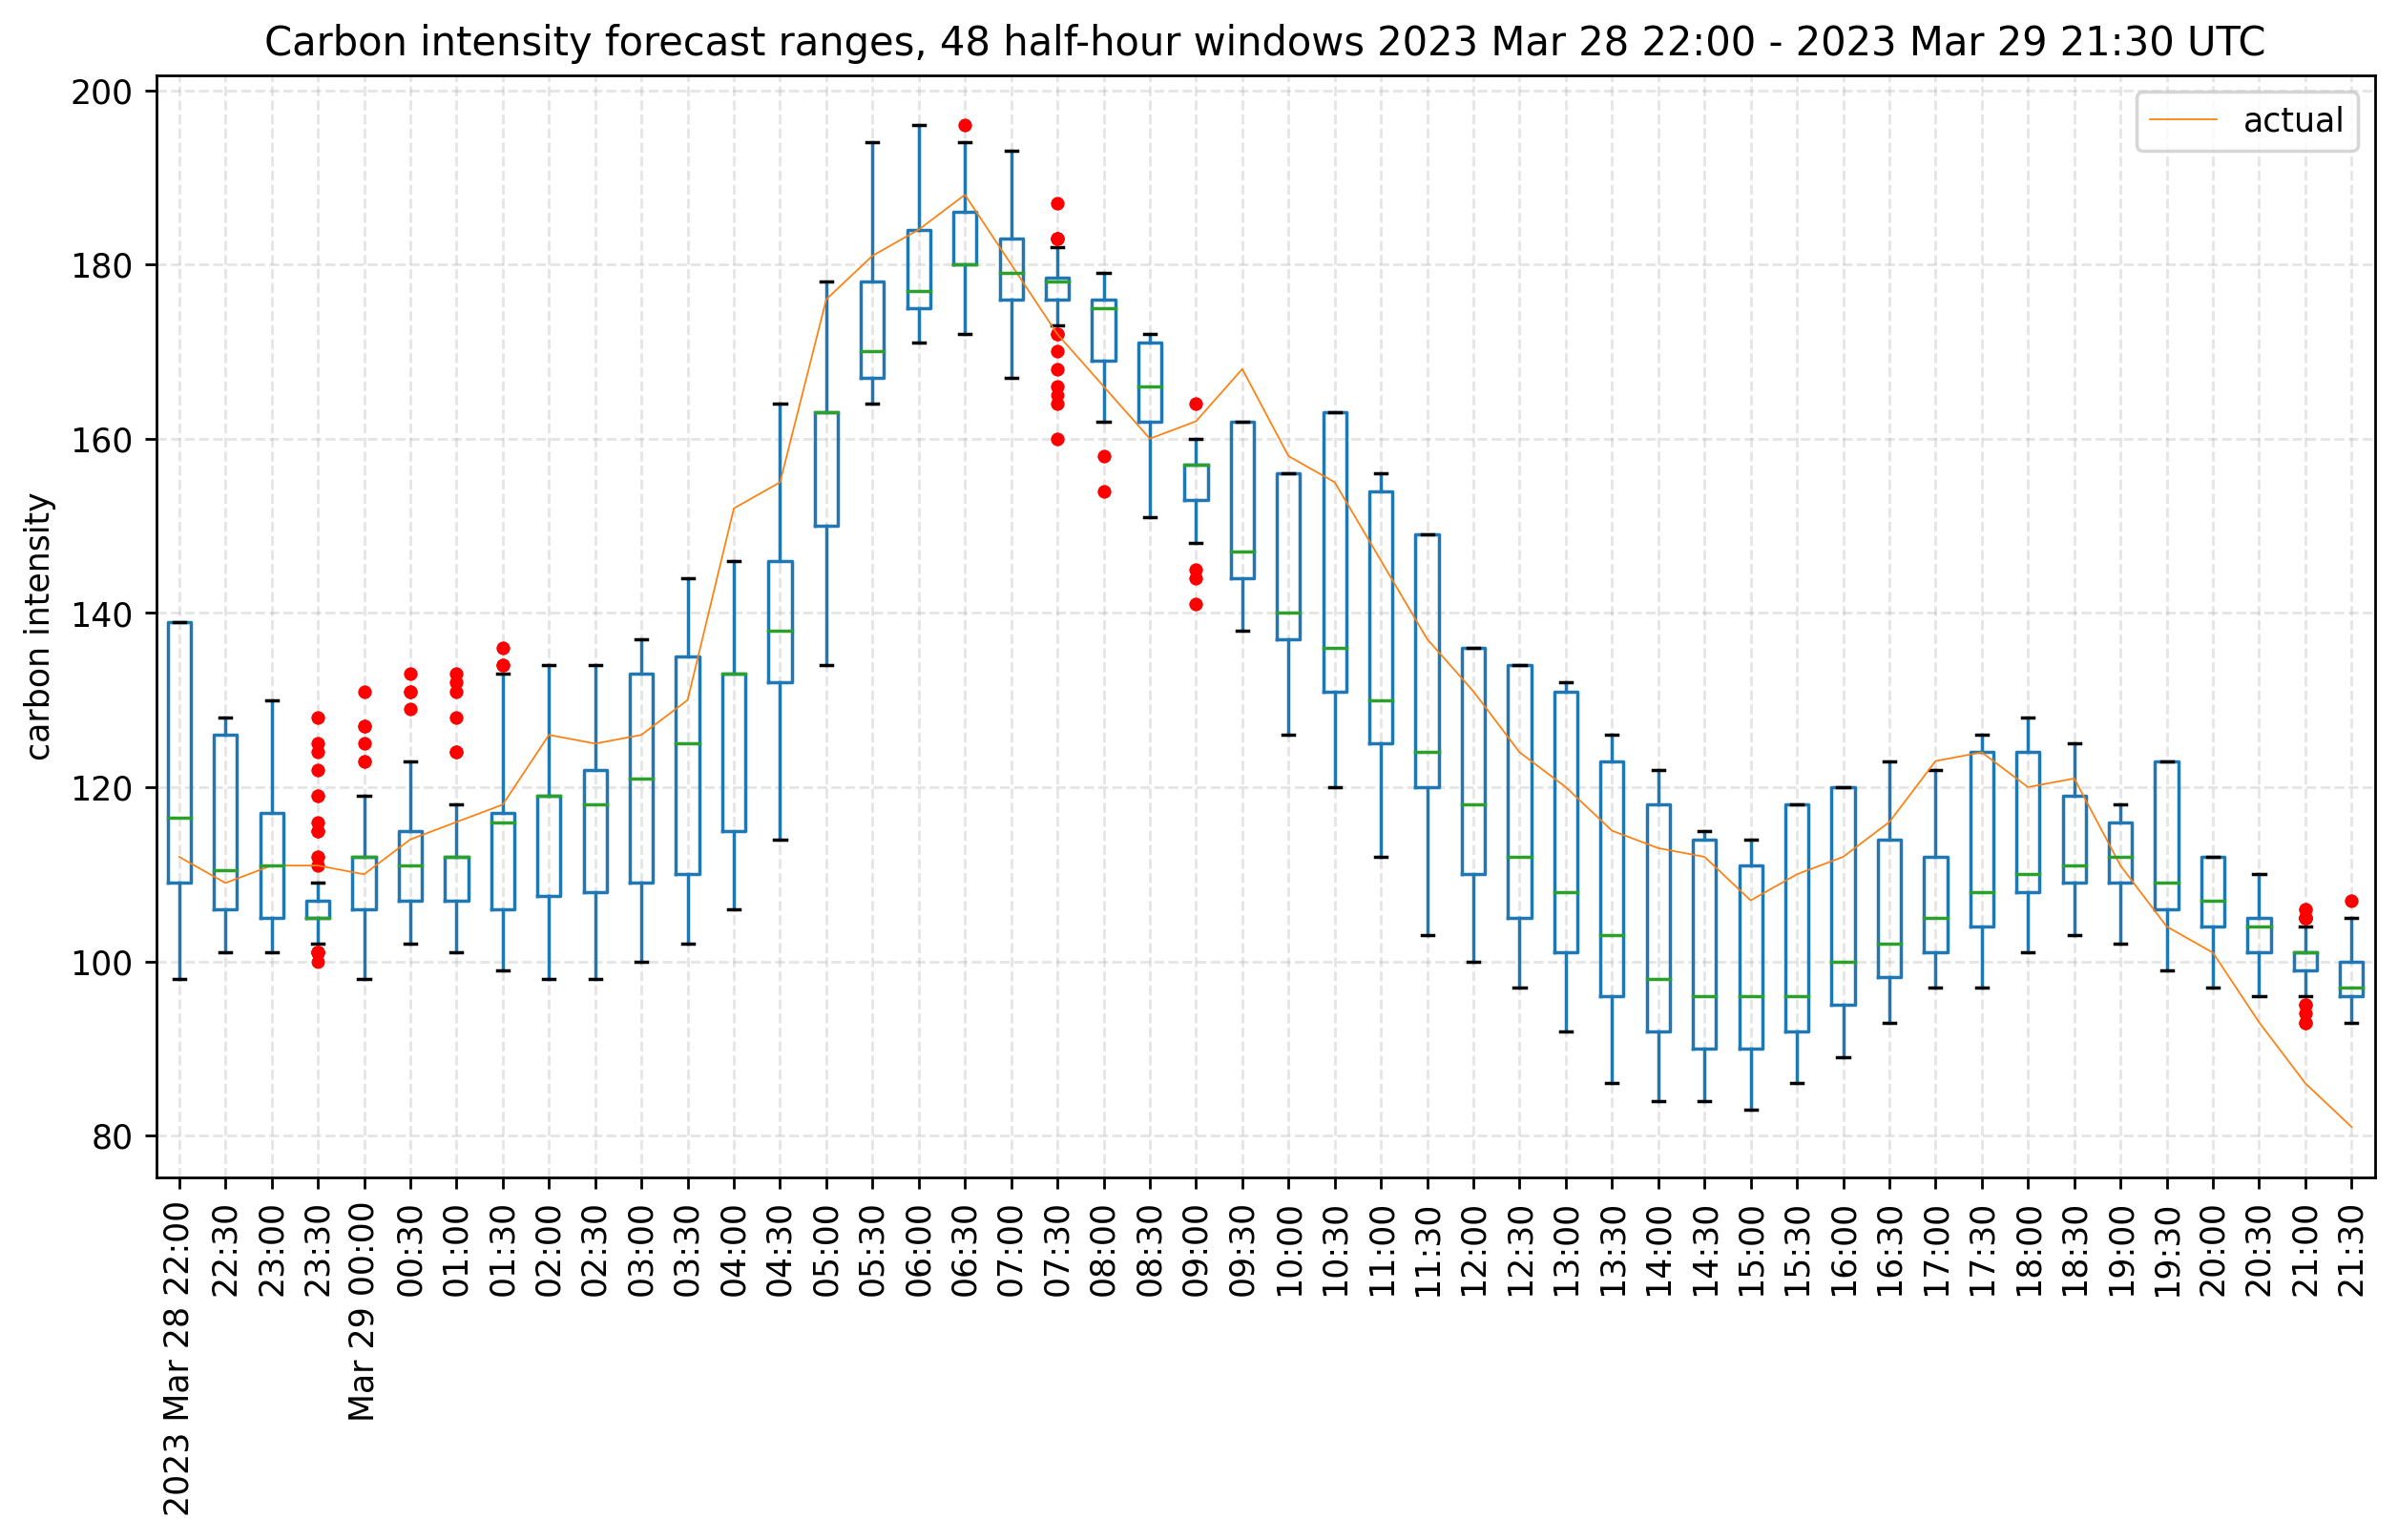

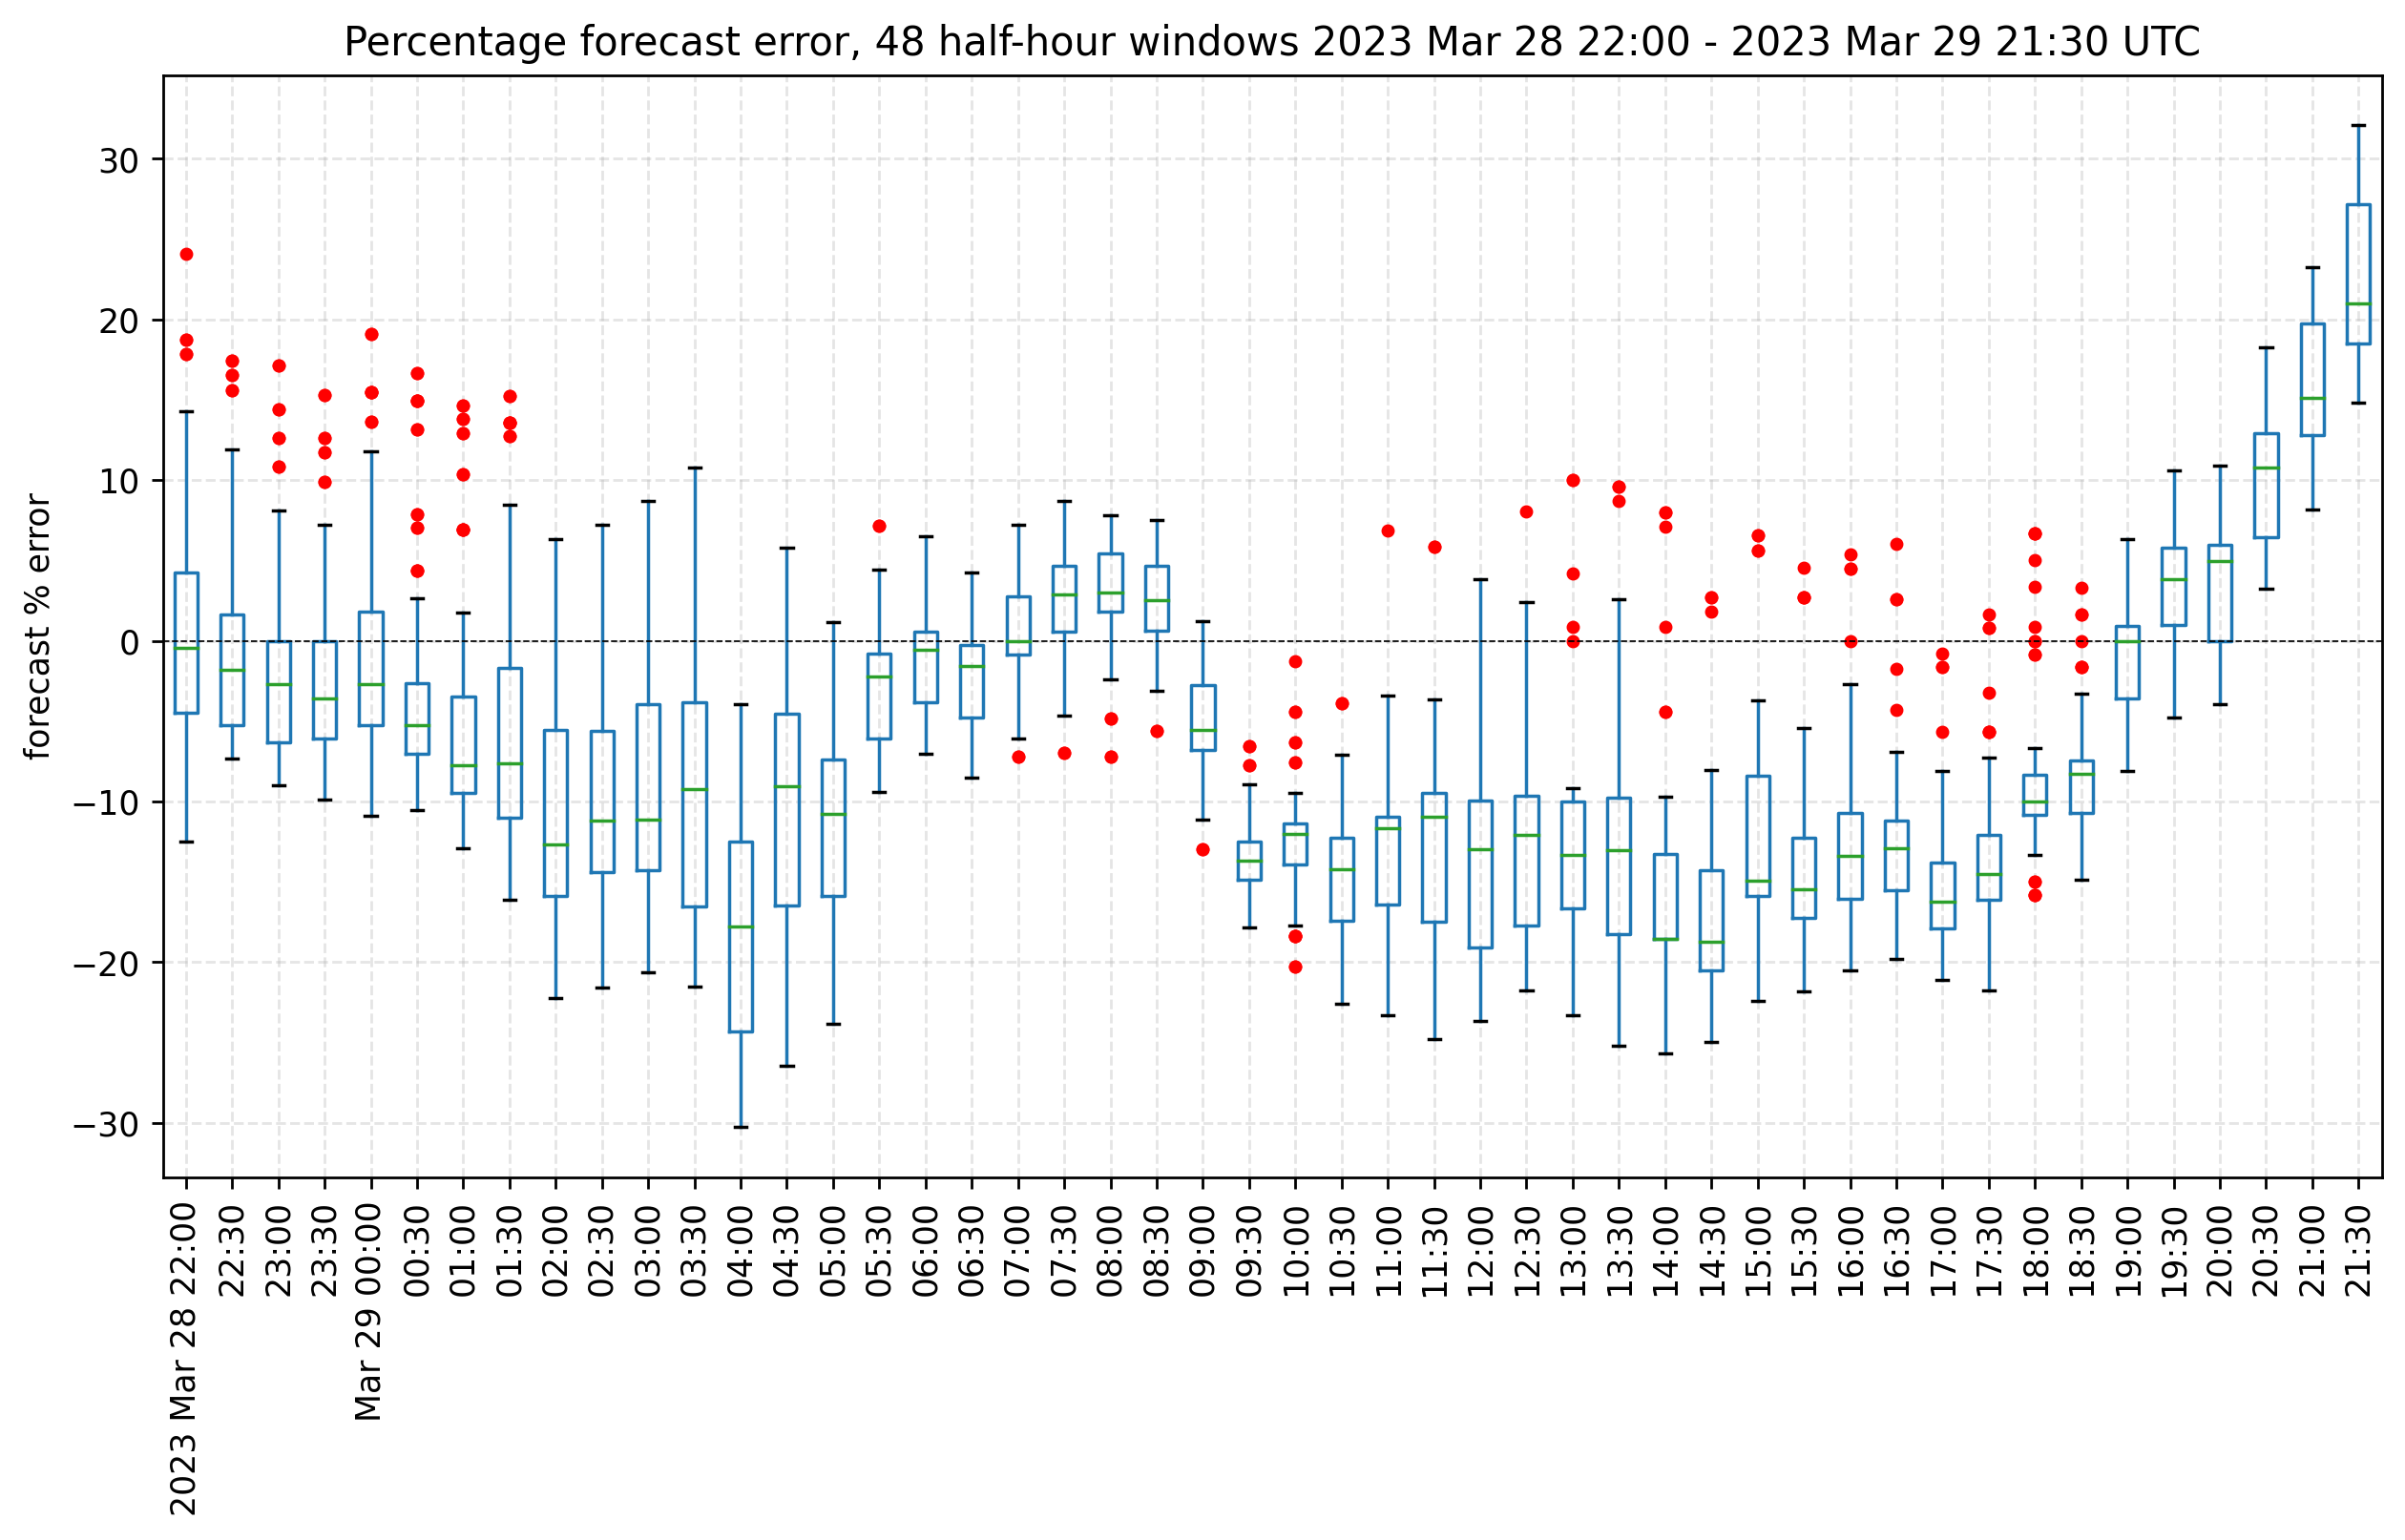

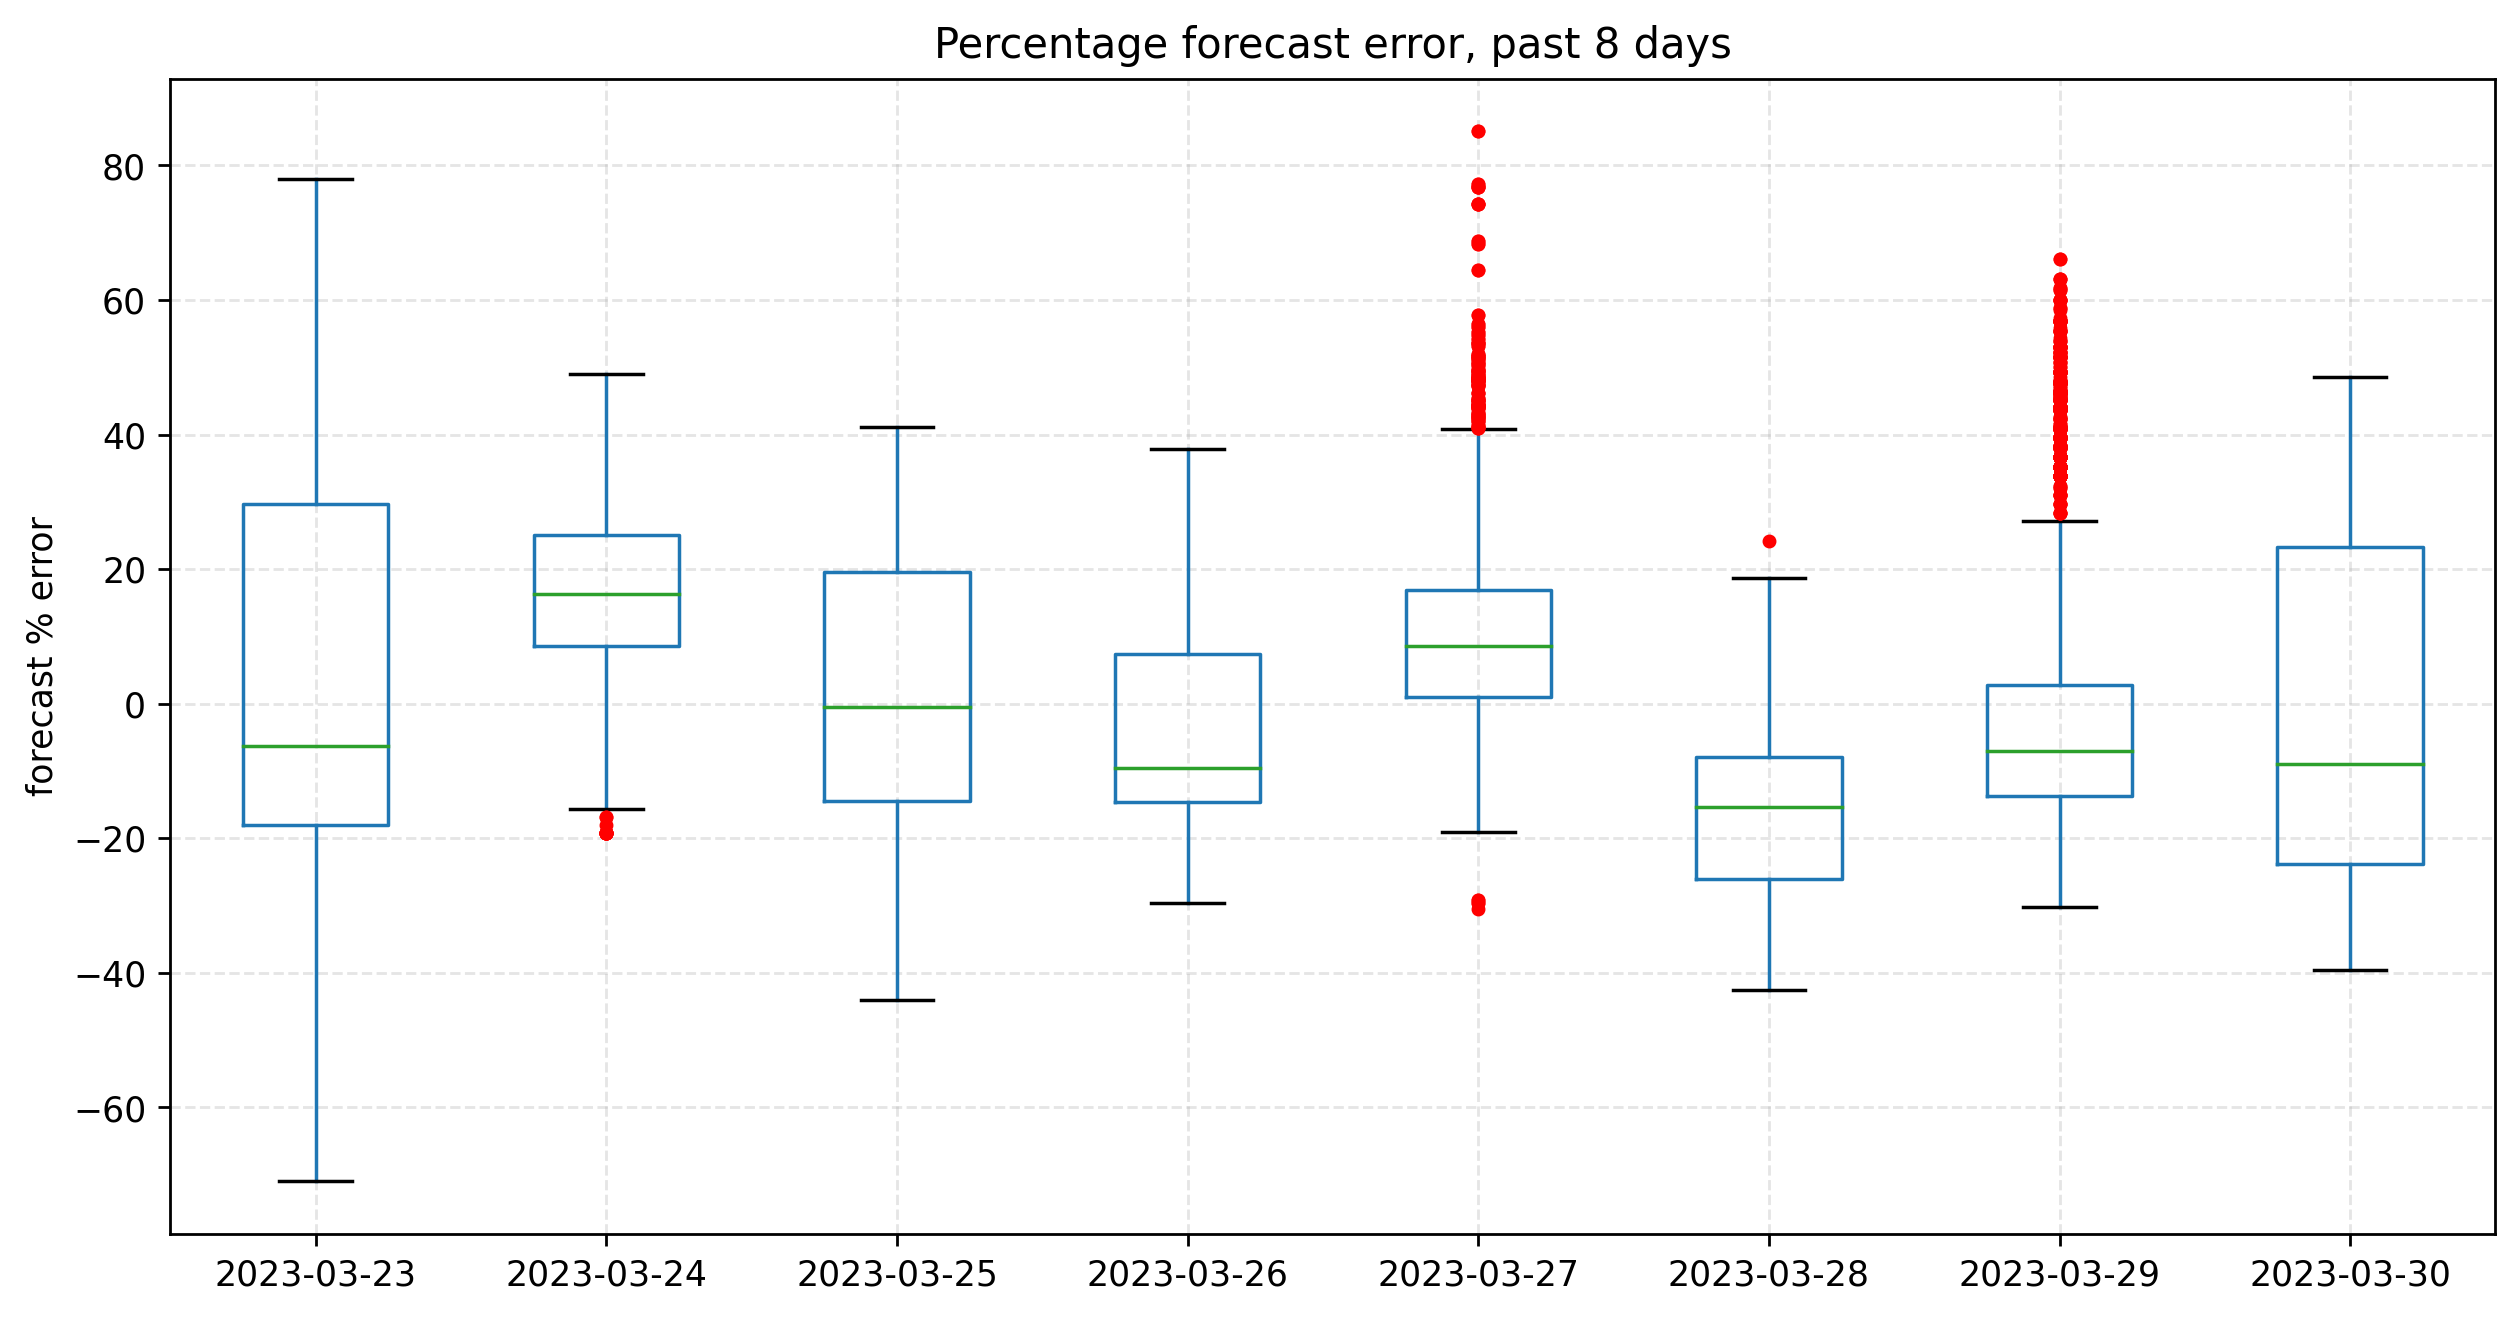

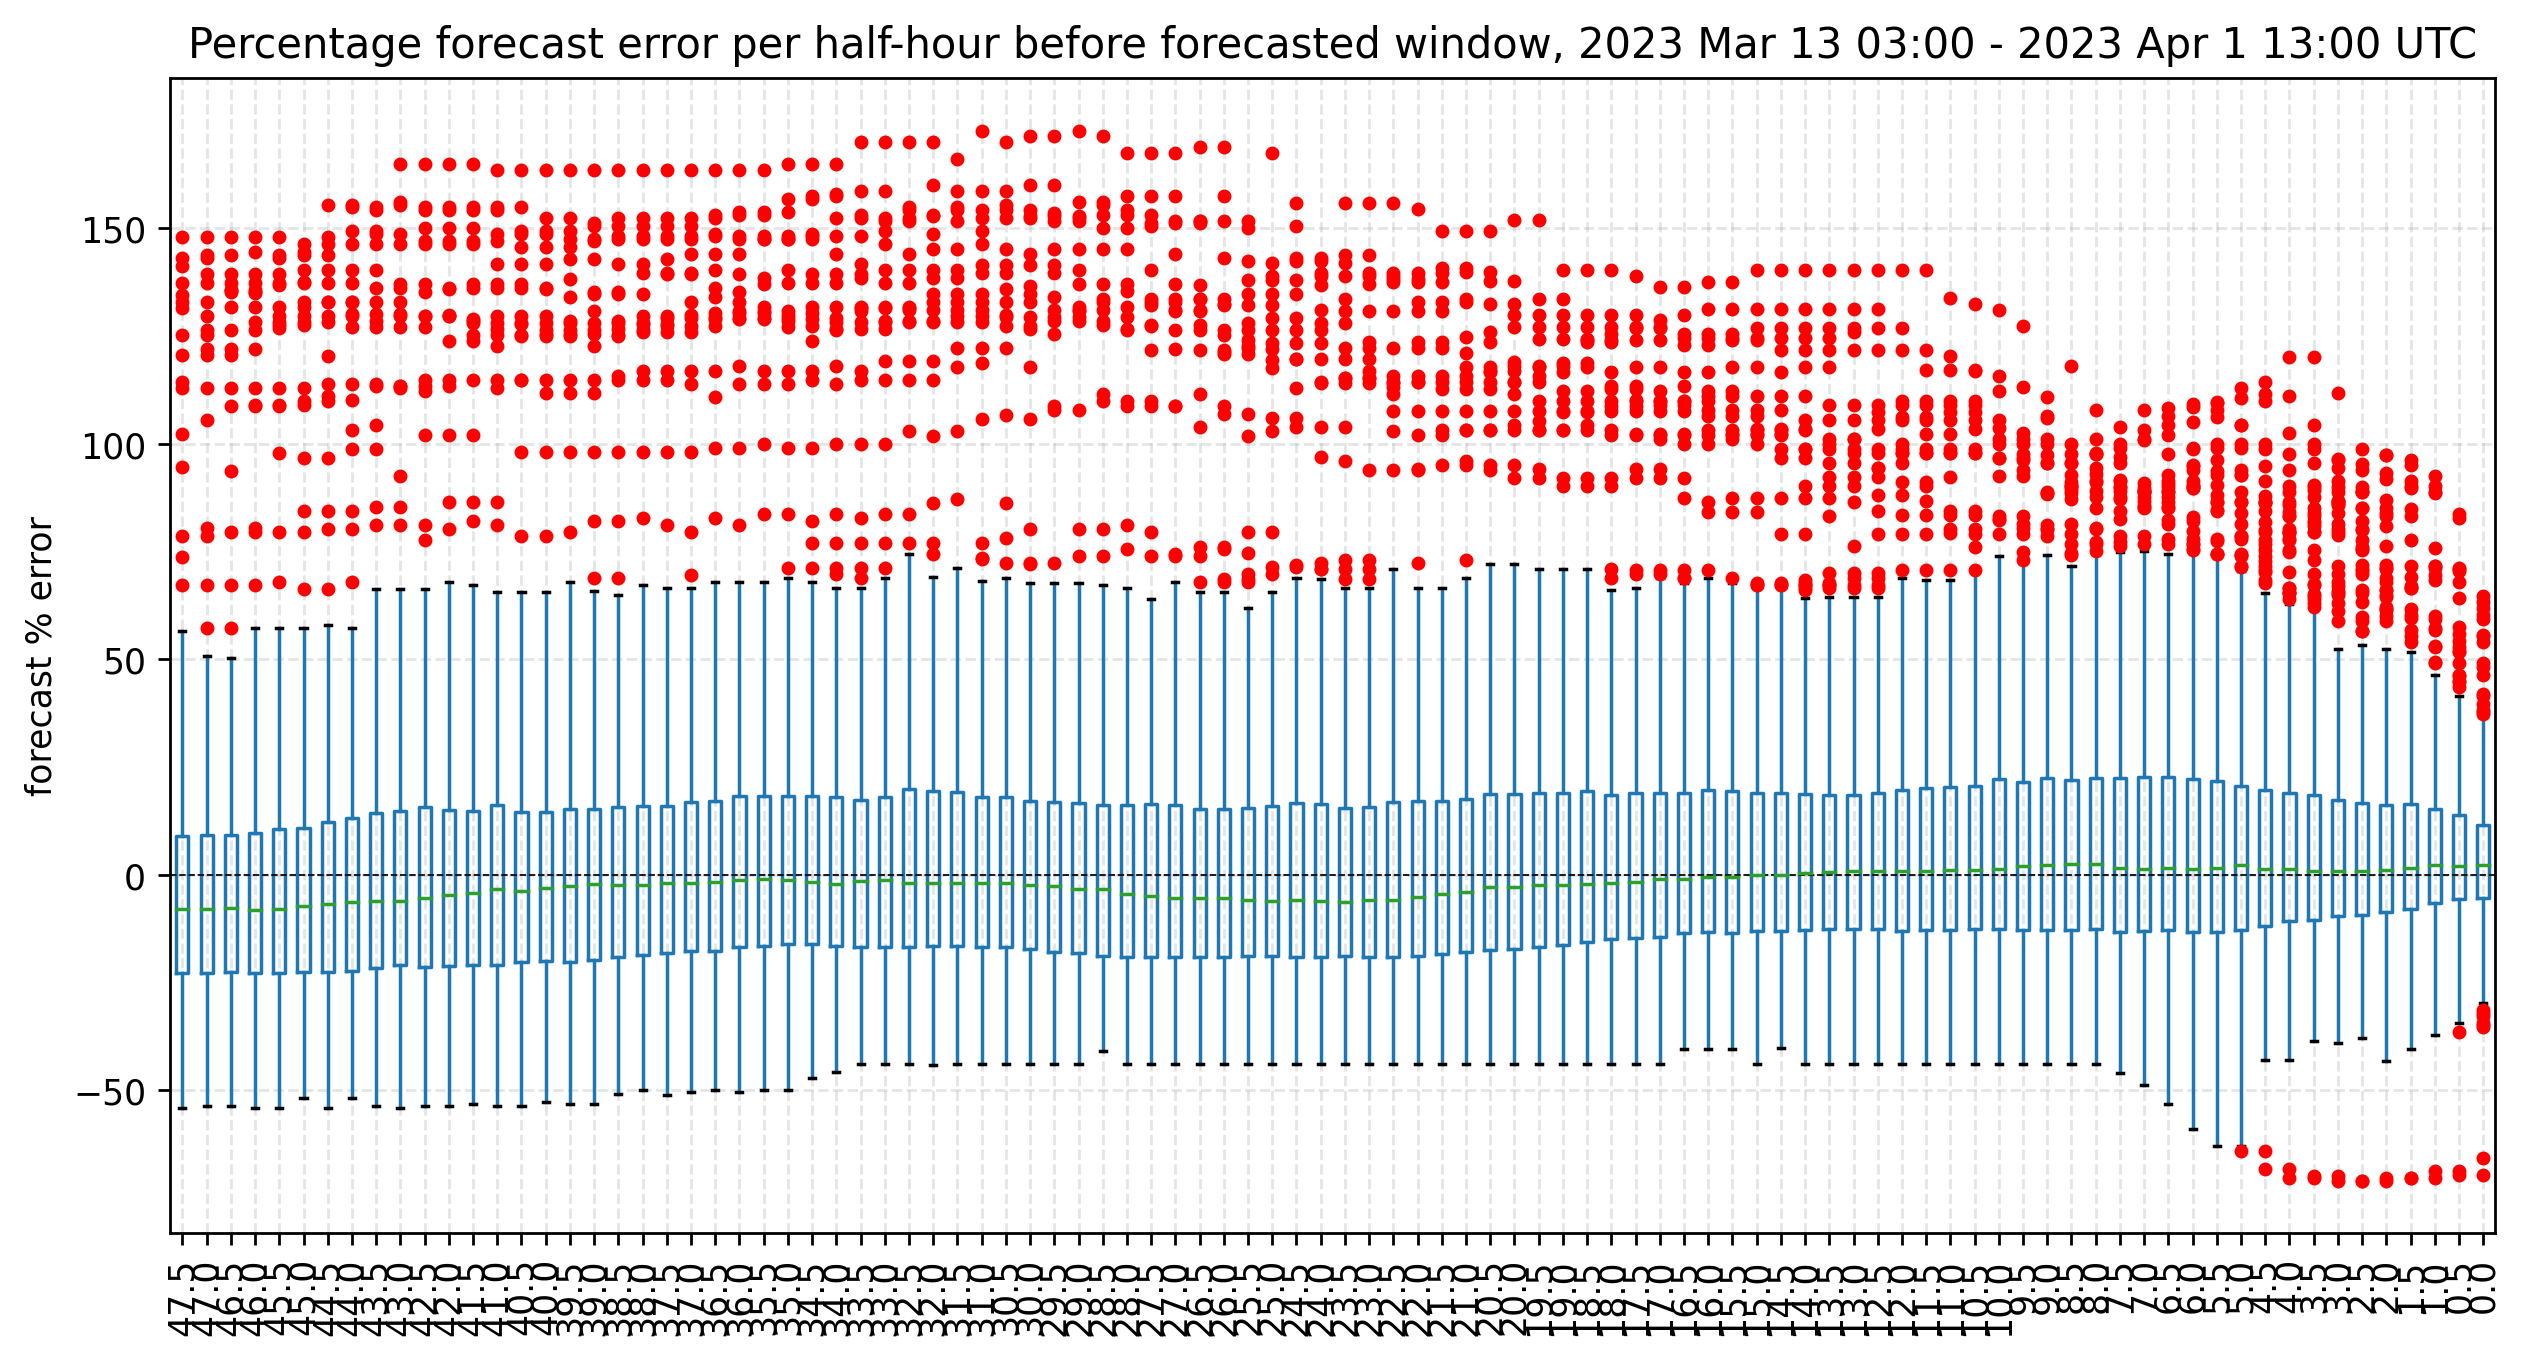

In [9]:
create_graph_images("data", hours_of_data=24)

In [ ]:
fig = generate_plot_ci_lines("data", hours_of_data=12)

In [ ]:
fig = generate_boxplot_ci("data", 24)

In [ ]:
fig = generate_boxplot_ci_error("data", 24)

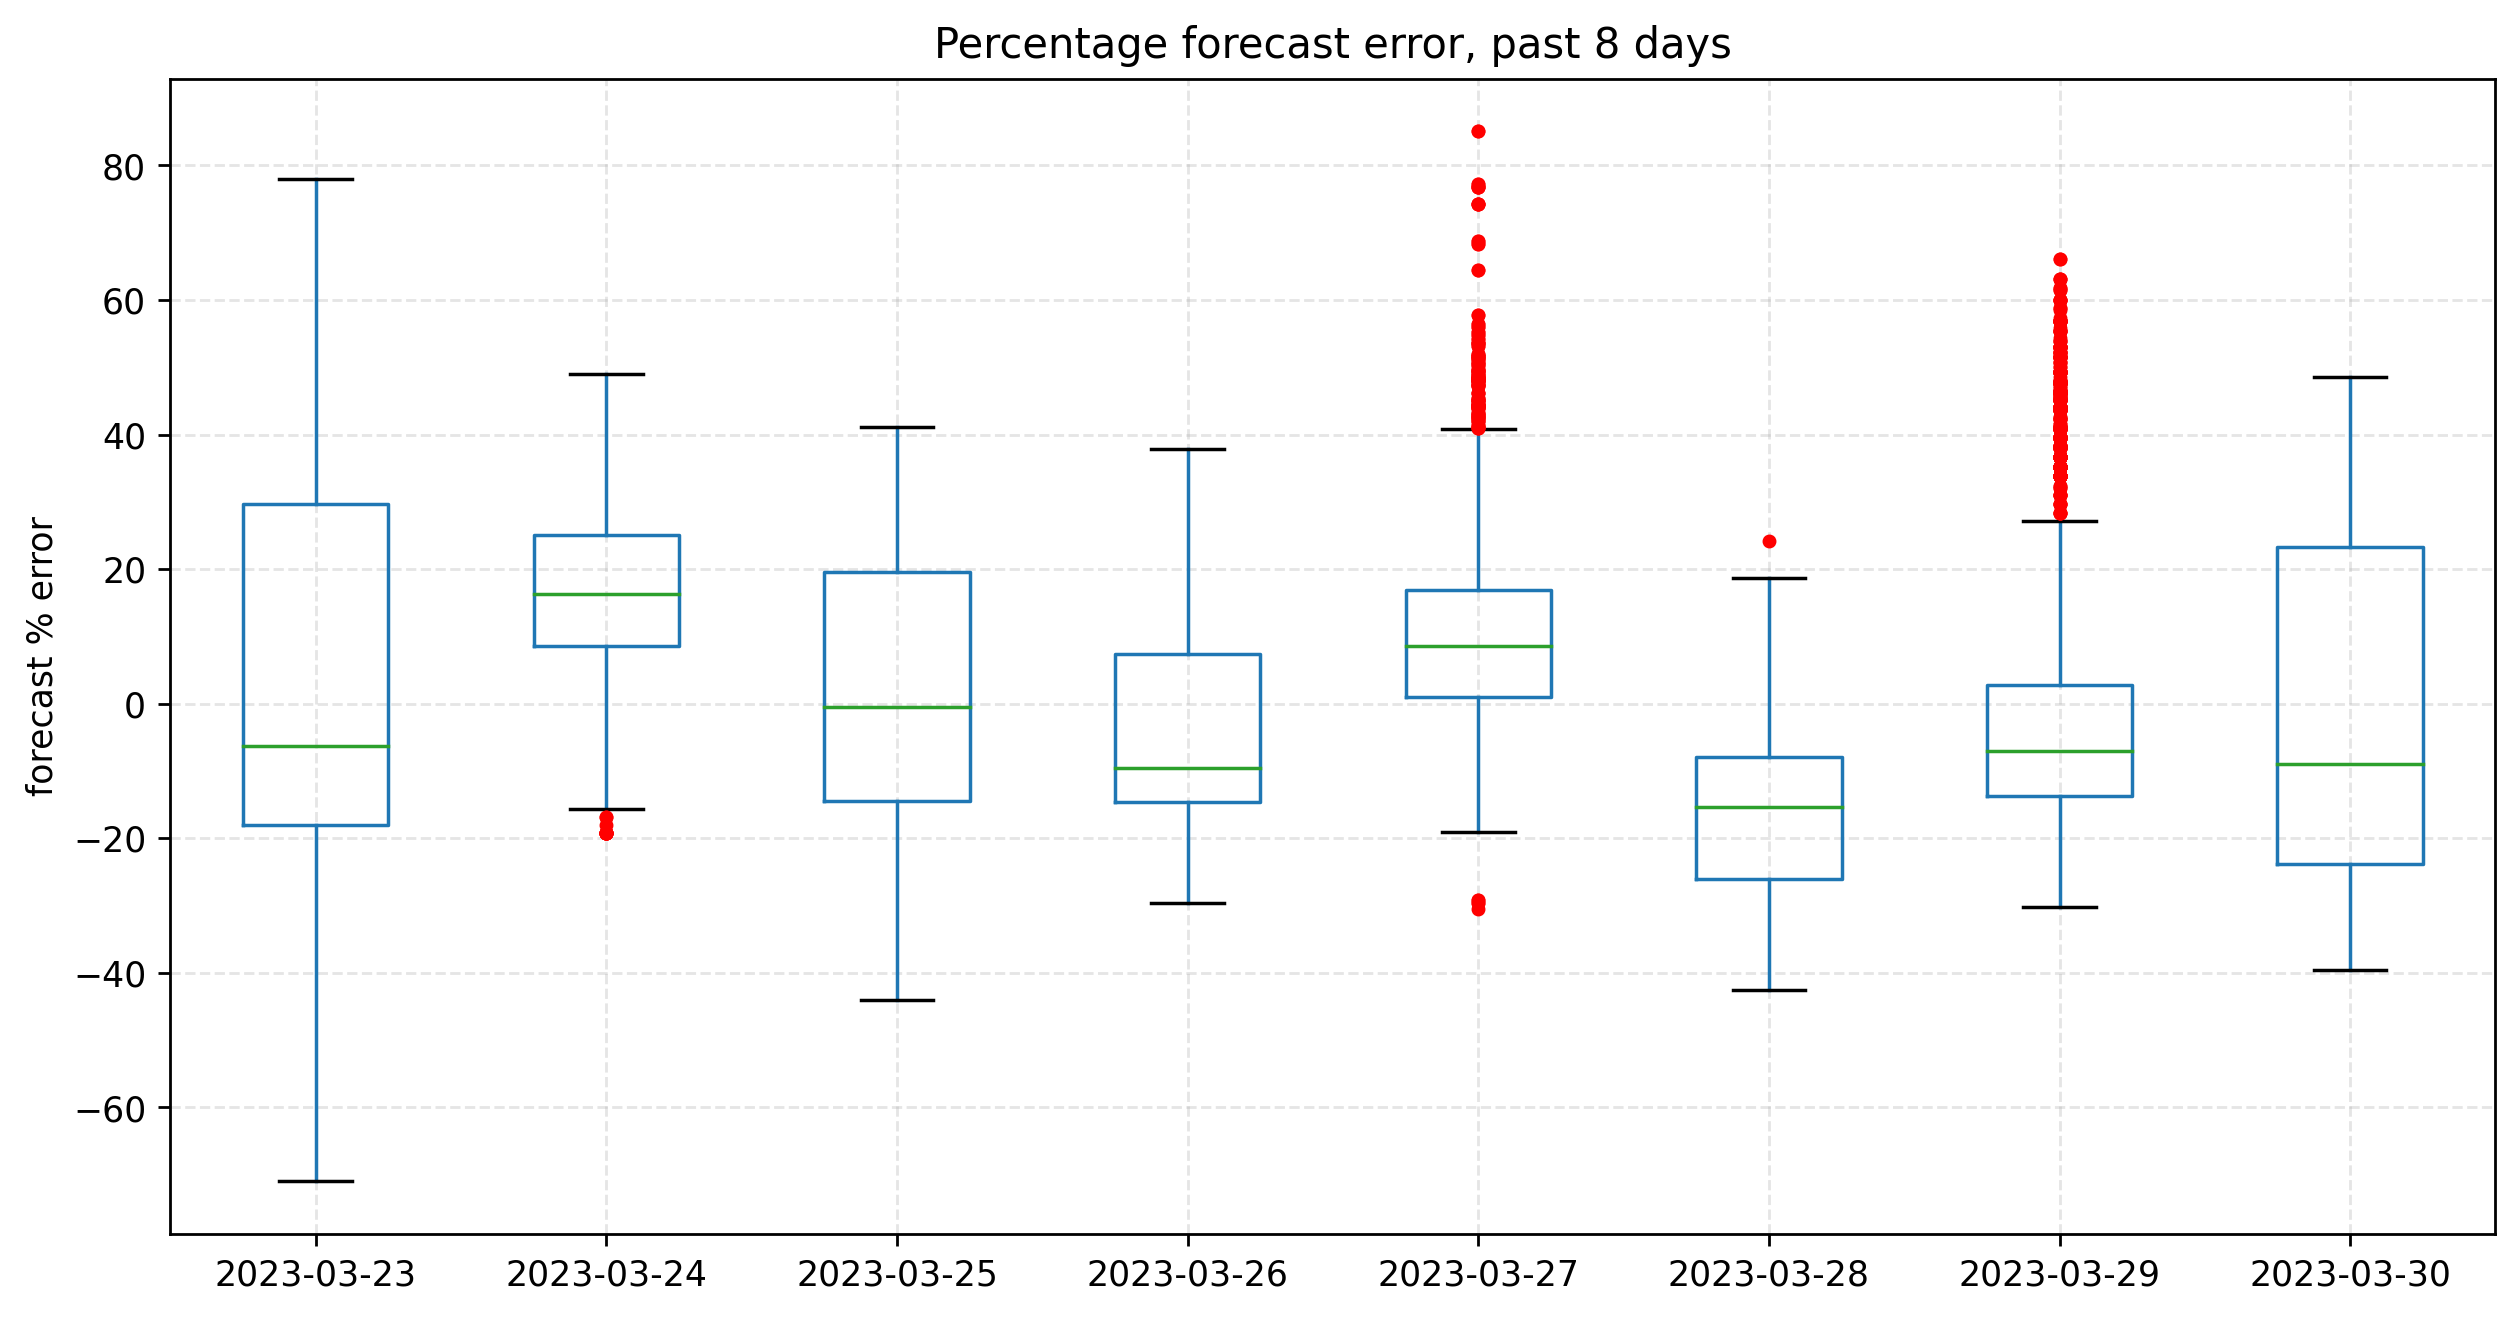

In [5]:
fig = generate_boxplot_ci_error_for_days("data", 7)

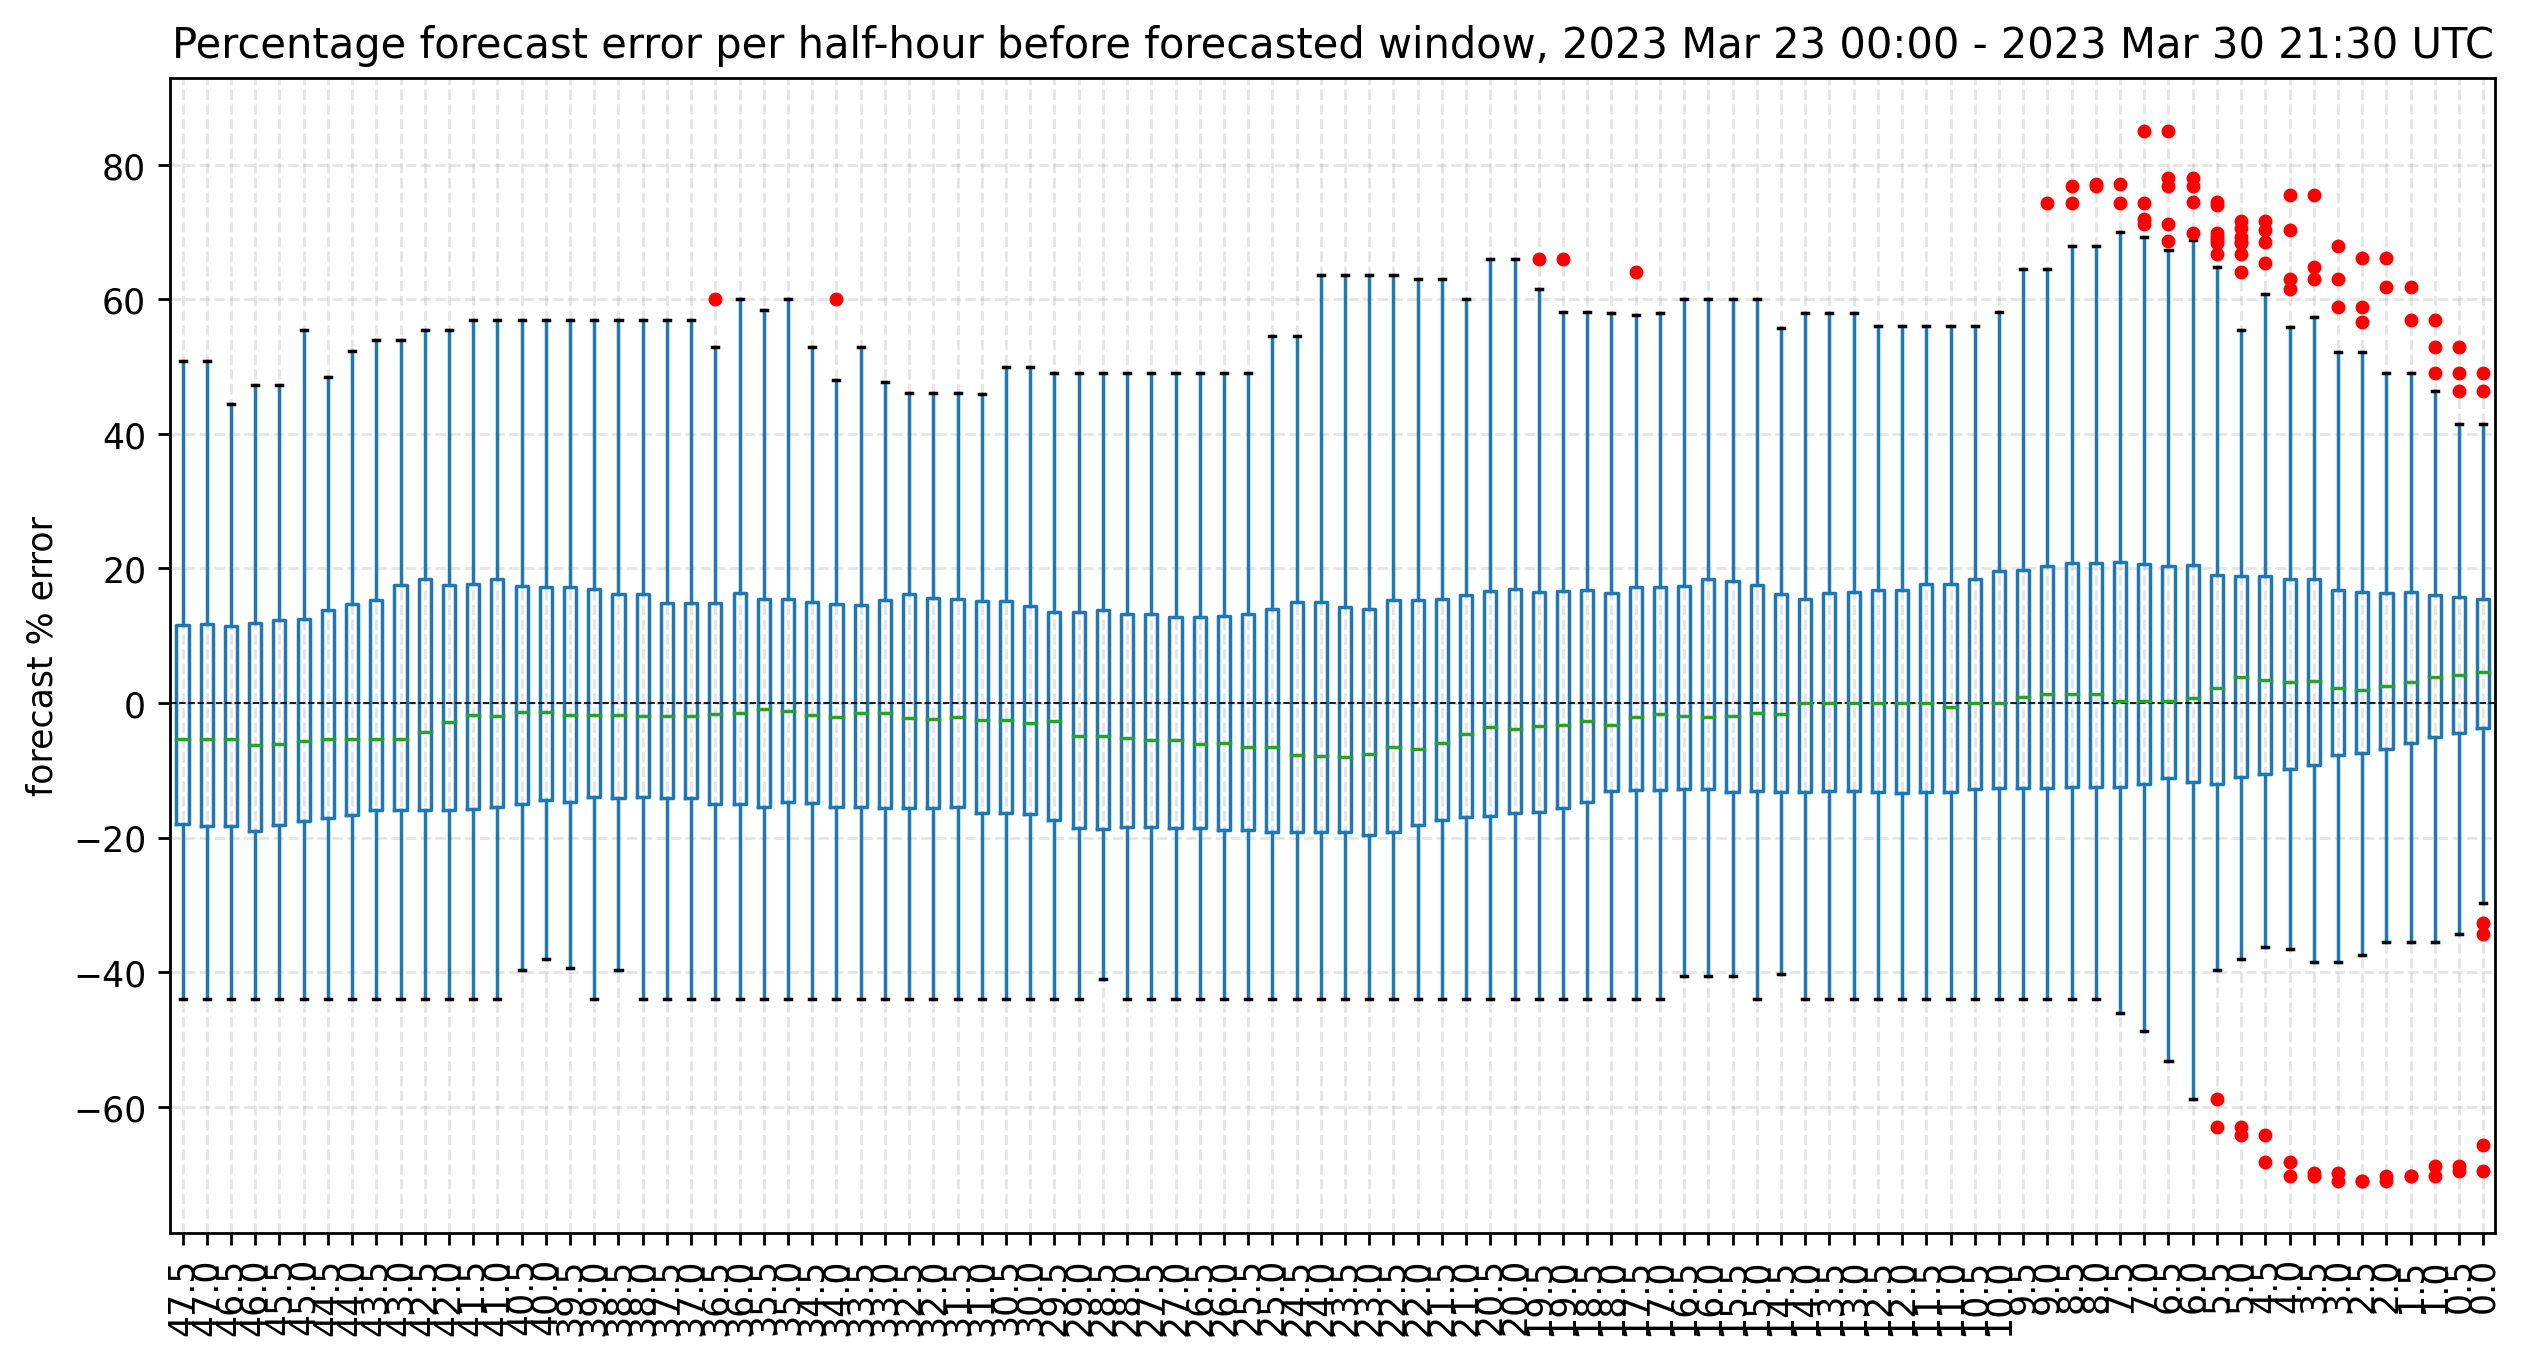

In [6]:
fig = generate_boxplot_ci_error_per_hour("data", days=7)